In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import re
import string



spark = SparkSession.builder \
    .appName("Hypothesis2_FromHDFS") \
    .getOrCreate()


df_spark = spark.read.csv("hdfs://localhost:54310/user/hadoop/data/okcupid_clean.csv", header=True, inferSchema=True)


df_spark = df_spark.select("orientation", "full_profile").dropna()

df = df_spark.toPandas()

# Filter out placeholder "."
df = df[(df["orientation"] != ".") & (df["full_profile"] != ".")]


art_keywords = [
    'music', 'musician', 'sing', 'singer', 'song', 'band', 'concert',
    'cinema', 'movie', 'film', 'director', 'actor', 'actress',
    'art', 'artist', 'painting', 'sculpture', 'gallery', 'drawing', 'photography'
]

def count_art_mentions(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    return sum(len(re.findall(rf"\b{word}\b", text)) for word in art_keywords)

df["art_mentions"] = df["full_profile"].apply(count_art_mentions)


result = df.groupby("orientation")["art_mentions"].mean().sort_values(ascending=False)


print("Average Art Mentions by Orientation:")
print(result)

25/06/24 22:42:45 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/06/24 22:42:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 22:42:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/24 22:42:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/24 22:42:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/24 22:42:48 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
                                                                                

Average Art Mentions by Orientation:
orientation
gay         1.652630
bisexual    1.593455
straight    1.593124
Name: art_mentions, dtype: float64


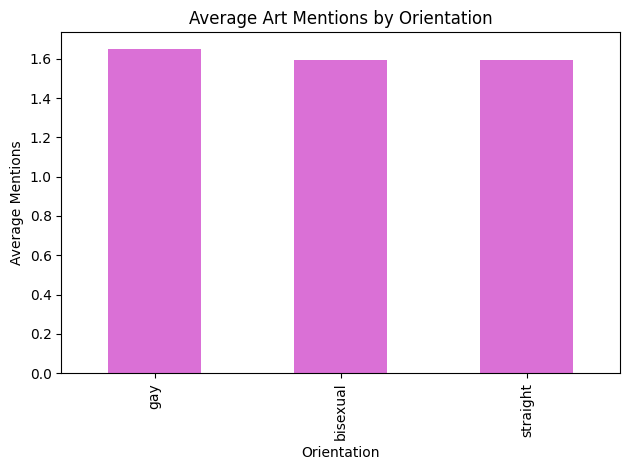

In [2]:
import matplotlib.pyplot as plt

result.plot(kind="bar", title="Average Art Mentions by Orientation", ylabel="Average Mentions", xlabel="Orientation", color="orchid")
plt.tight_layout()
plt.show()